# Dimensionality Reduction

Notebook originally created by Aurélien Géron to accompany his book:\
Hands-On Machine Learning with Scikit-Learn and TensorFlow (2nd ed)

Modified by PvD 11/2022

### Motivations and Drawbacks 

    The main motivations for dimensionality reduction are:
    * To visualize the data and gain insights on the most important features
    * To save space (compression)
    * To speed up a subsequent training algorithm (in some cases it may even remove noise and redundant features, making the training algorithm perform better)
    
    The main drawbacks are:
    * Some information is lost, possibly degrading the performance of subsequent training algorithms.
    * It can be computationally intensive.
    * Transformed features are often hard to interpret.


## Setup

This project requires Python 3.7 or above:

In [2]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# PCA

### Visualizing what PCA does

Let's generate a small 3D dataset. It's an oval shape, rotated in 3D space, with points distributed unevenly, and with quite a lot of noise:

In [52]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

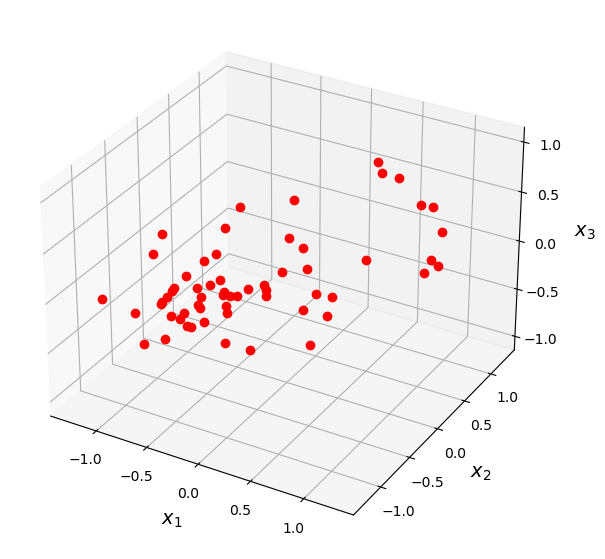

In [58]:
import matplotlib.pyplot as plt

X_centered = X - X.mean(axis=0)


axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

# plot samples 
for i in range(m):
        ax.plot(X[i][0],X[i][1],X[i][2],'ro')

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

Plot the 3D dataset, with the projection plane.

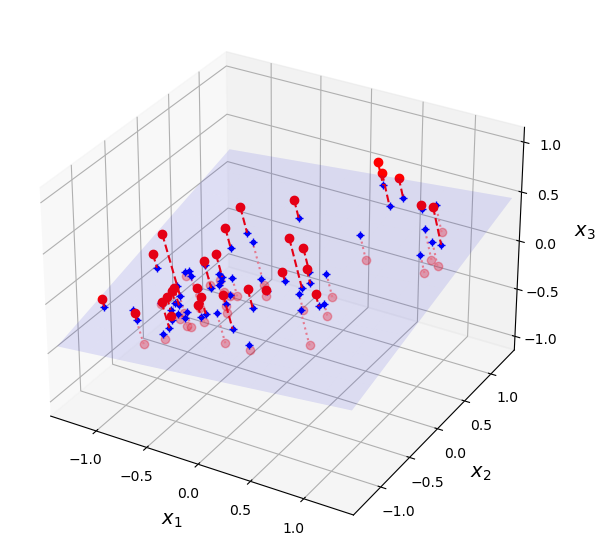

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

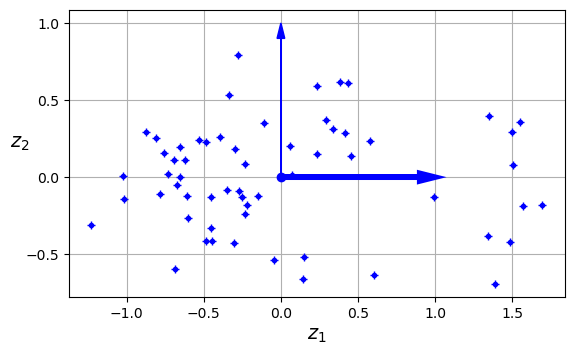

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)


## Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

## Explained Variance Ratio

Now let's look at the explained variance ratio:

In [10]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

The first dimension explains about 76% of the variance, while the second explains about 15%.

By projecting down to 2D, we lost about 9% of the variance:

In [11]:
1 - pca.explained_variance_ratio_.sum()  # extra code

0.09028309326742046

## Choosing the Right Number of Dimensions

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [13]:
d

154

In [14]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [15]:
pca.n_components_

154

In [16]:
pca.explained_variance_ratio_.sum()

0.9501960192613034

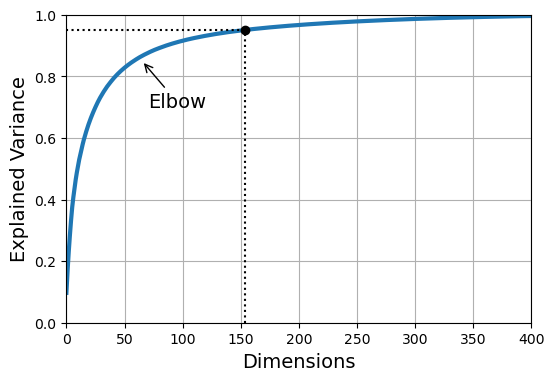

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

## Using PCA for Compression

In [18]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [19]:
X_recovered = pca.inverse_transform(X_reduced)

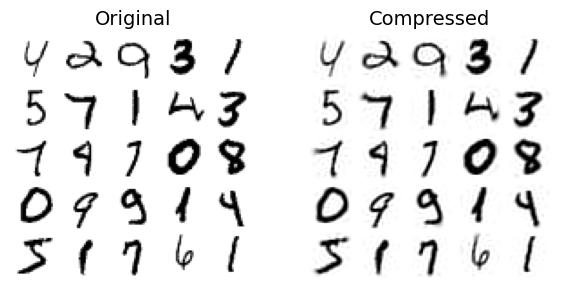

In [20]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")


# Example of PCA to (hopefully) speed-up a training algorithm

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

Exercise: _Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [22]:
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

Exercise: _Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set._

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [24]:
%time rnd_clf.fit(X_train, y_train)

Wall time: 34.9 s


RandomForestClassifier(random_state=42)

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

Exercise: _Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%._

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

Exercise: _Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?_

In [29]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

Wall time: 1min 17s


RandomForestClassifier(random_state=42)

Oh no! Training is actually about twice slower now! How can that be? 

    Dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm.  

Let's check the precision of the new random forest classifier.

Exercise: _Next evaluate the classifier on the test set: how does it compare to the previous classifier?_

In [30]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some potentially useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training *and* reduced performance. 😭

Exercise: _Try again with an `SGDClassifier`. How much does PCA help now?_

In [31]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

Wall time: 2min 13s


SGDClassifier(random_state=42)

In [32]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.874

Okay, so the `SGDClassifier` takes much longer to train on this dataset than the `RandomForestClassifier`, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help `SGDClassifier`. Let's train it using the reduced dataset:

In [33]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

Wall time: 24.2 s


SGDClassifier(random_state=42)

Nice! Reducing dimensionality led to roughly 5× speedup. :)  Let's check the model's accuracy:

In [34]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8959

Great! PCA not only gave us a 5× speed boost, it also improved performance slightly.

So there you have it: PCA can give you a formidable speedup, and if you're lucky a performance boost... but it's really not guaranteed: it depends on the model and the dataset!

# Using Dimensionality Reduction for Visualization

Exercise: _Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class._

Let's limit ourselves to the first 5,000 images of the MNIST training set, to speed things up a lot.

In [35]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

Let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

Wall time: 23.1 s


Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

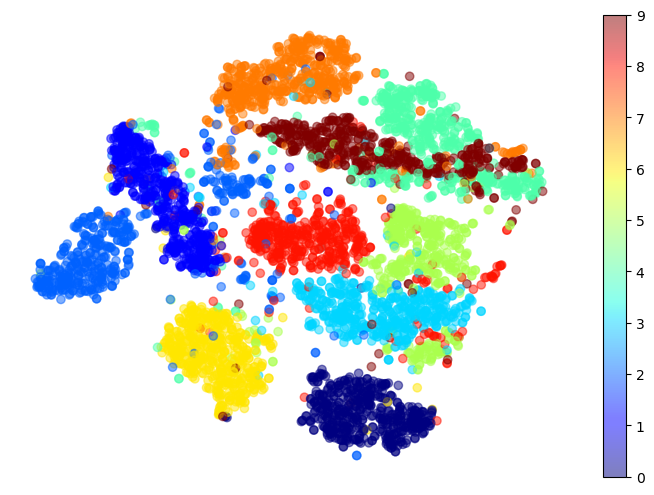

In [47]:
plt.figure(figsize=(9, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) Most digits are nicely separated from the others, even though t-SNE wasn't given the targets: it just identified clusters of similar images. But there is still a bit of overlap. For example, the 3s and the 5s overlap a lot (on the right side of the plot), and so do the 4s and the 9s (in the top-right corner).

Let's focus on just the digits 4 and 9:

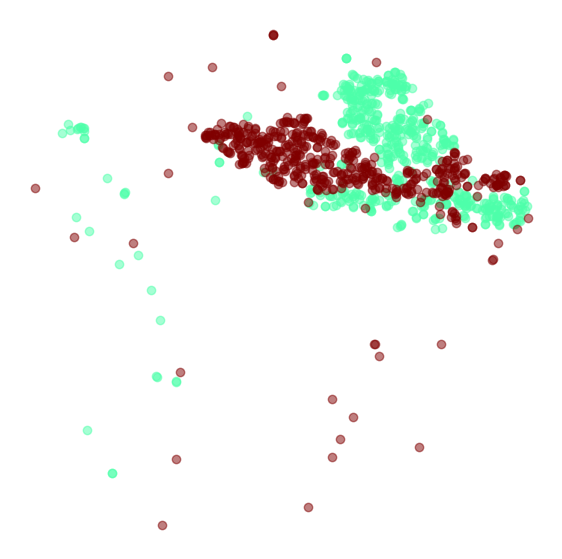

In [48]:
plt.figure(figsize=(7, 7))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on just these 2 digits:

In [39]:
idx = (y_sample == '4') | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

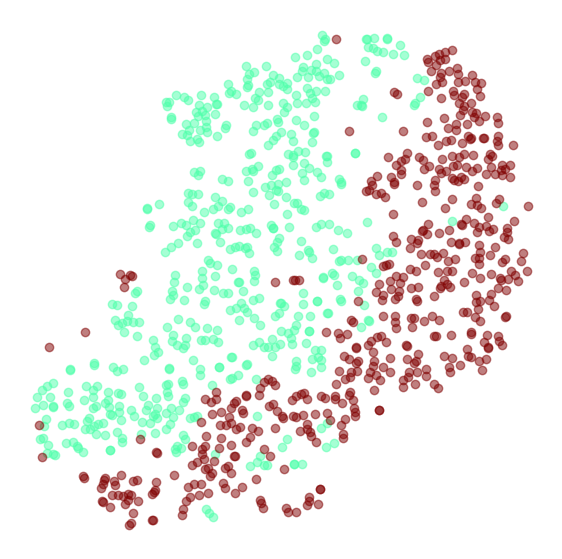

In [49]:
plt.figure(figsize=(7, 7))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

That's much better, although there's still a bit of overlap. Perhaps some 4s really do look like 9s, and vice versa. It would be nice if we could visualize a few digits from each region of this plot, to understand what's going on. In fact, let's do that now.

Exercise: _Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits._

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [41]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(11, 8)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's show colored digits (not images), for all 5,000 images:

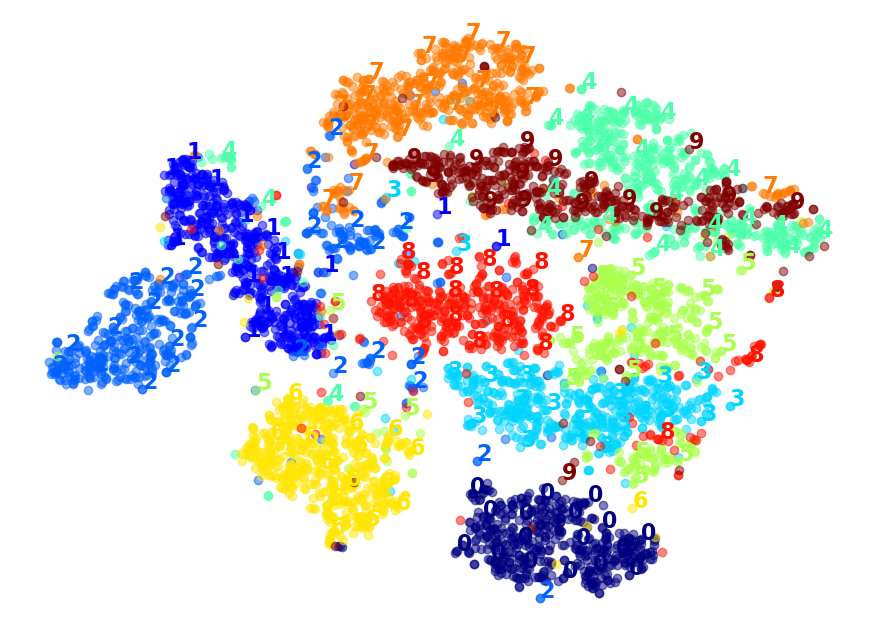

In [42]:
plot_digits(X_reduced, y_sample)

Well that's okay, but not that beautiful. Let's try with the digit images:

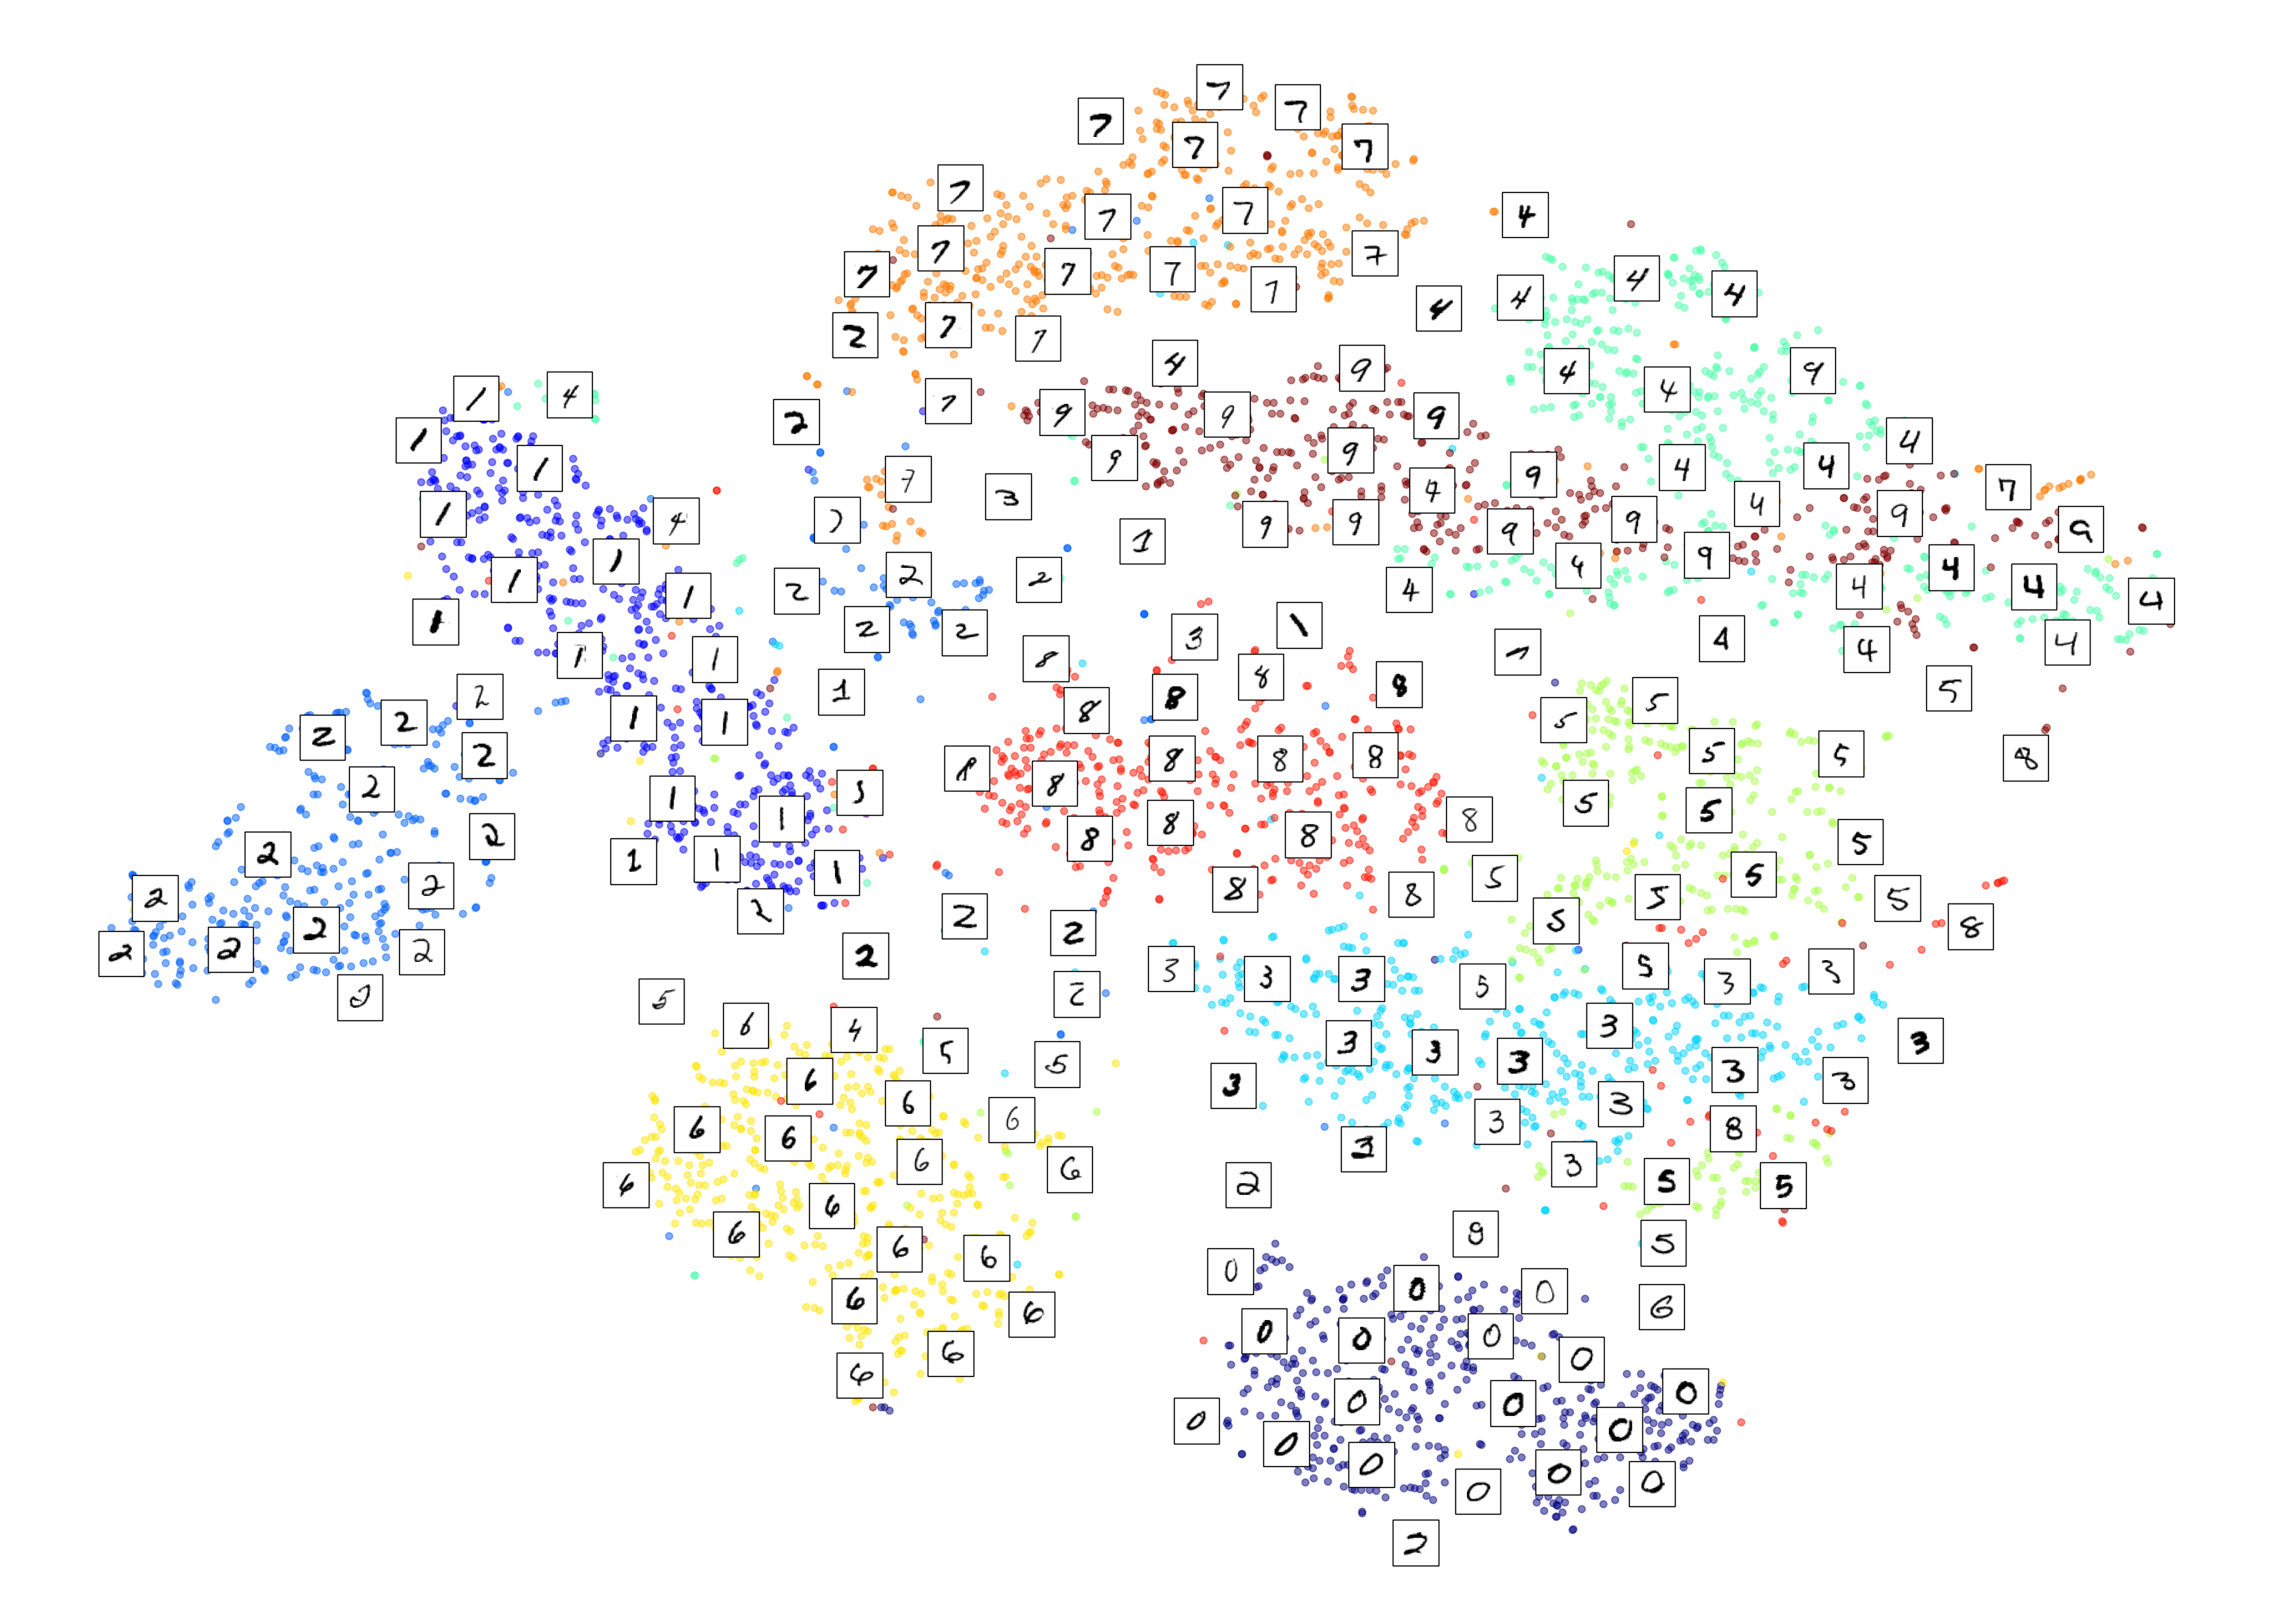

In [43]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

That's nicer! Now let's focus on just the 4s and the 9s:

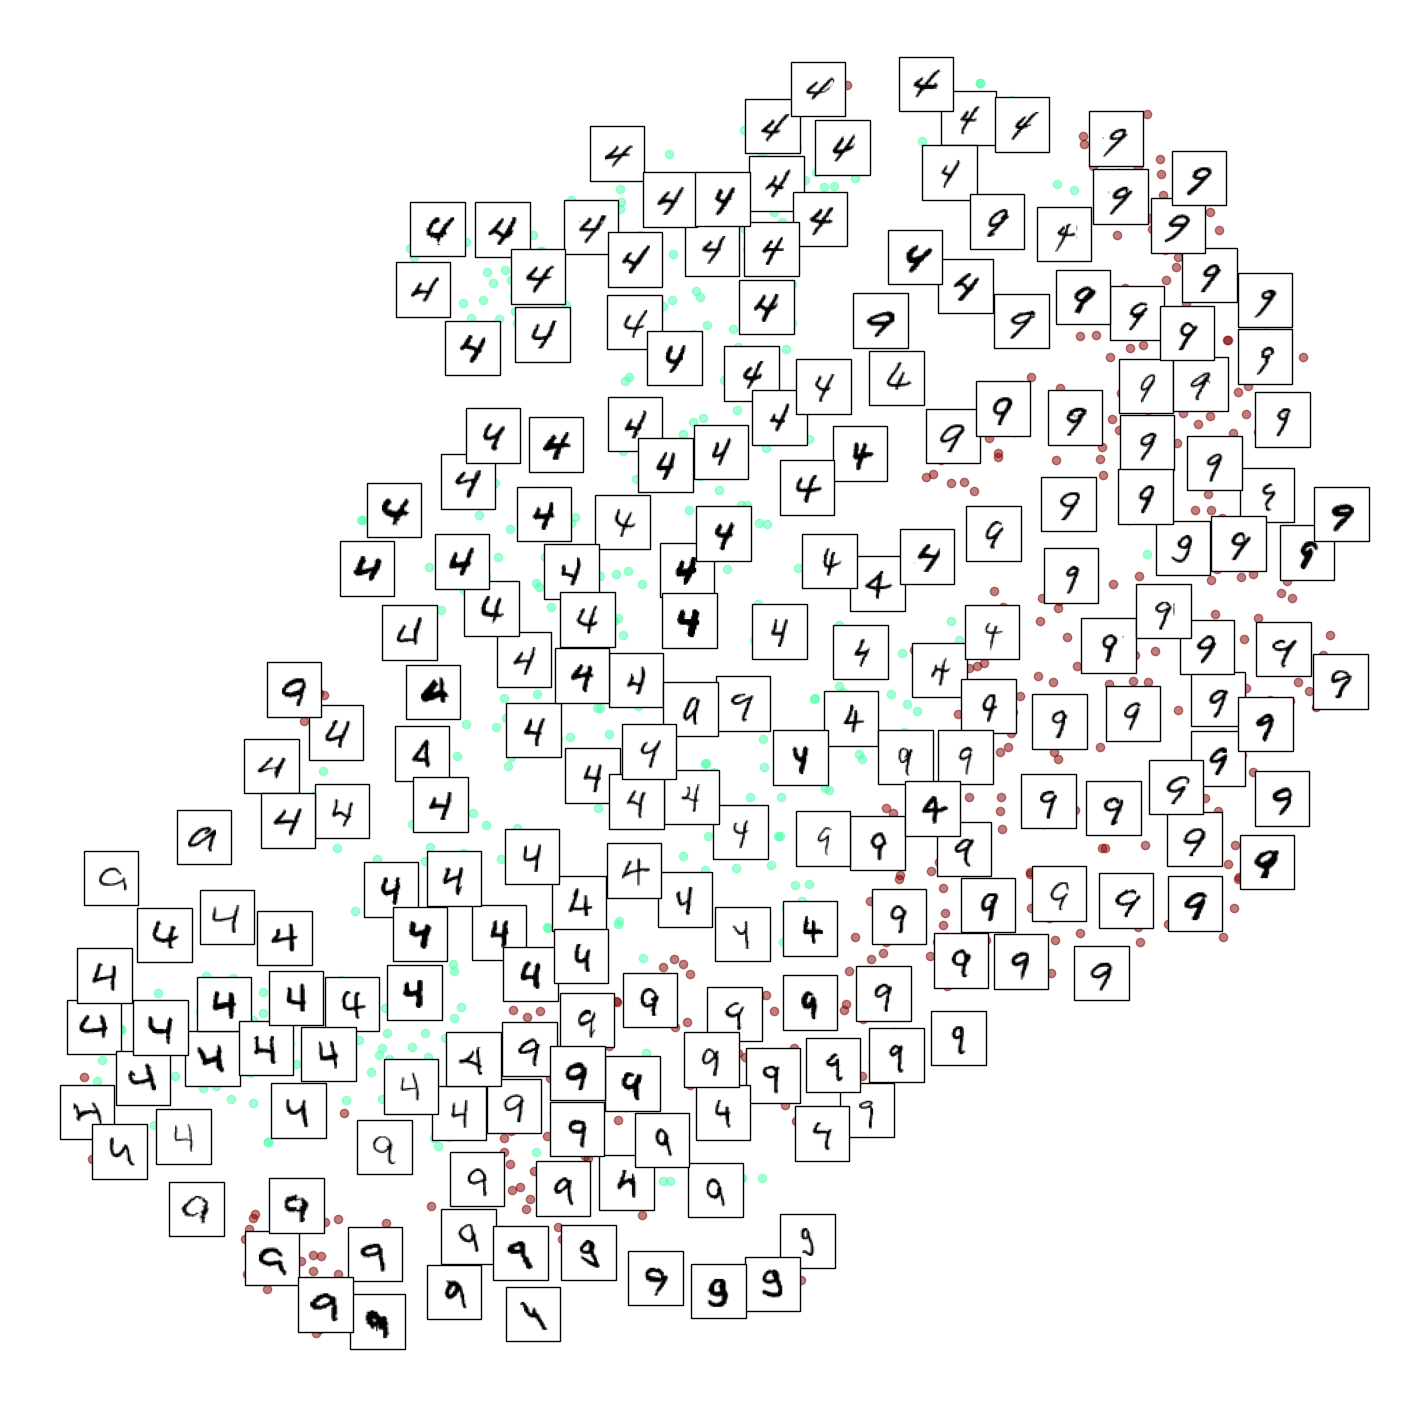

In [50]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(18, 18))

Notice how similar-looking 4s are grouped together. For example, the 4s get more and more inclined as they approach the top of the figure. The inclined 9s are also closer to the top. Some 4s really do look like 9s, and vice versa.

Exercise: _Try using another dimensionality reduction algorithm (PCA) compare the resulting visualizations._

Using PCA. We will also time how long it takes:

Wall time: 105 ms


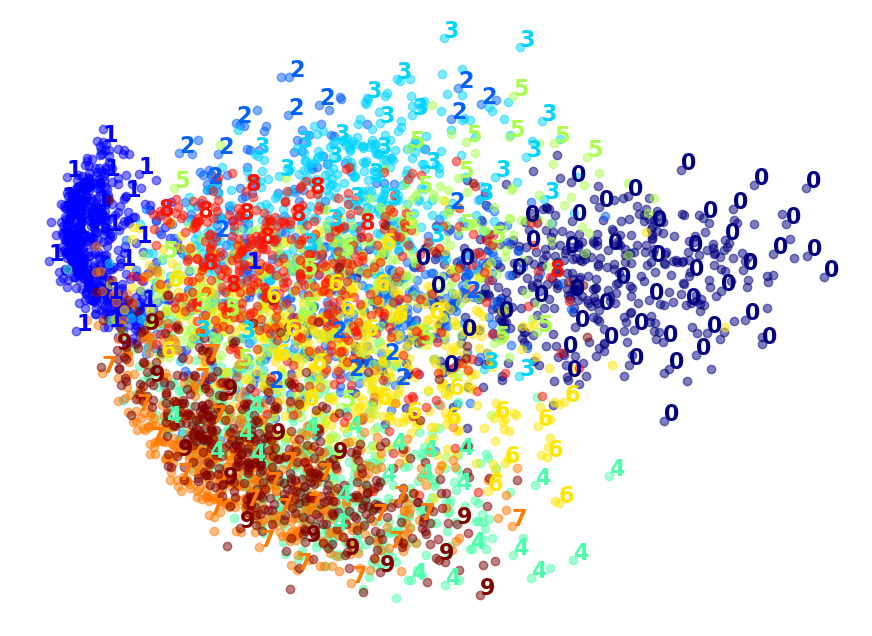

In [45]:
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. 